# Assignment - Week 2

1. First, build a code for a perceptron(i.e. a single neuron and no hidden layers) and build a AND gate using it.
2. Now, try to build a XOR gate using a perceptron and share your results with us.
3. Implement a XOR gate again, this time you can use a single hidden layer.
4. Build a full adder using the perceptron you have built
5. Combine the adders into a ripple carry adder

In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget

In [4]:
# define truth table of AND and XOR gates
x_2 = np.array(
    [[0, 0], [0, 1], [1, 0], [1, 1]]
).T

# (A, B, Cin)
x_3 = np.array(
    [[0,0,0], [0,0,1], [0,1,0], [0,1,1], [1,0,0], [1,0,1], [1,1,0], [1,1,1]]
).T

y_and = np.array([[0, 0, 0, 1]])

y_xor = np.array([[0, 1, 1, 0]])

# (Cout, S)
y_carry_adder = np.array(
    [[0,0], [0,1], [0,1], [1,0], [0,1], [1,0], [1,0], [1,1]]
).T

## Implementing a single perceptron gate

`SinglePerceptronGate` implements a perceptron thats takes in exactly two inputs, and produces a *discrete* output $y_{\text{pred}} \in \{0,1\}$.

Weights and biases are stored as $(1,2)$ and $(1,1)$ size `np.ndarray`'s resp. and randomly initialized.

Activation function used is the Heaviside step function $H(x) = 1 (x \geq 0), \quad H(x) = 0 (\text{otherwise})$.

The standard learning algorith is used:
$$\mathbf{w(t+1)} = \mathbf{w(t)} + \sum_j \eta (y_j - \hat{y}_j) x_j$$
where sum is carried out over $j$ or number of samples, $\hat{y}$ or $y_{\text{pred}}$ is the perceptron's predicted output, and $\eta$ is the learning rate.

### Reference
https://en.wikipedia.org/wiki/Perceptron

In [5]:
class SinglePerceptronGate:
    def __init__(self):
        self.W = np.random.randn(1, 2)
        self.B = np.random.randn(1, 1)
        
    @staticmethod
    def step_fn(z):
        return np.array(z >= 0, dtype=np.float64)

    def apply(self, x):
        '''
        x has shape (2, n_samples)
        '''
        
        z = self.W @ x + self.B
        y_pred = self.step_fn(z)
        
        return y_pred
    
    @staticmethod
    def error(y_pred, y):
        # used with + sign
        return y - y_pred
    
    def learn(self, x, y, eta = 0.1):
        '''
        perform one iteration of learning rule:
        
            w -> w + Σ η * (y_j - y_pred_j) * x_j
            
            (w, x_j are vectors, sum is over j, i.e., all samples)
        
        assumes inputs are of correct type and shape
        '''
        n_samples = x.shape[1]
        
        y_pred = self.apply(x)
        
        e = self.error(y_pred, y)
        
        self.W += eta * e @ x.T
        self.B += eta * e @ np.ones((1, n_samples)).T
        
        # for debugging purposes
        return (y_pred, e)
    
    def inspect(self):
        print(f"Weights: {self.W[0][0]}, {self.W[0][1]}")
        print(f"Bias: {self.B[0][0]}")
    
    def train(self, x, y, epochs = 10, eta = 0.1):
        assert x.shape[0] == 2
        assert y.shape[0] == 1

        # ensure sample size is uniform
        assert x.shape[1] == y.shape[1]
        
        error_norm_history = []
        
        for epoch in range(1, epochs+1):
            y_pred, e = self.learn(x, y, eta)
            
            error_norm_history.append(np.linalg.norm(e))
            
        fig, ax = plt.subplots()
        ax.plot(np.arange(epochs), error_norm_history)
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Error Norm")
        # fig.show()

Predictions: [[0. 0. 0. 1.]]
Error: [[0. 0. 0. 0.]]
Weights: 1.6243453636632417, 2.3882435863499247
Bias: -2.5281717522634555


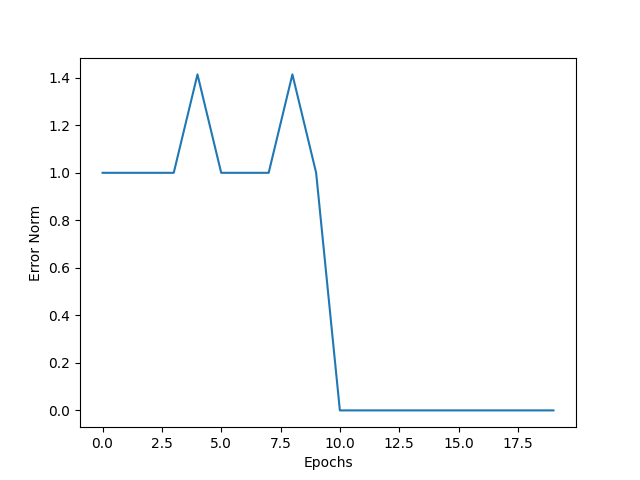

In [6]:
np.random.seed(1)  # predictable output
# initialize perceptron
and_gate = SinglePerceptronGate()

# train
and_gate.train(x_2, y_and, epochs=20, eta=1)

# test
test_input = x_2
expected = y_and
y_pred = and_gate.apply(test_input)
error = and_gate.error(y_pred, expected)
print("Predictions:", y_pred)
print("Error:", error)

and_gate.inspect()

Predictions: [[0. 0. 0. 0.]]
Error: [[0. 1. 1. 0.]]
Weights: 0.024345363663241276, -0.11175641365007544
Bias: -0.12817175226345573


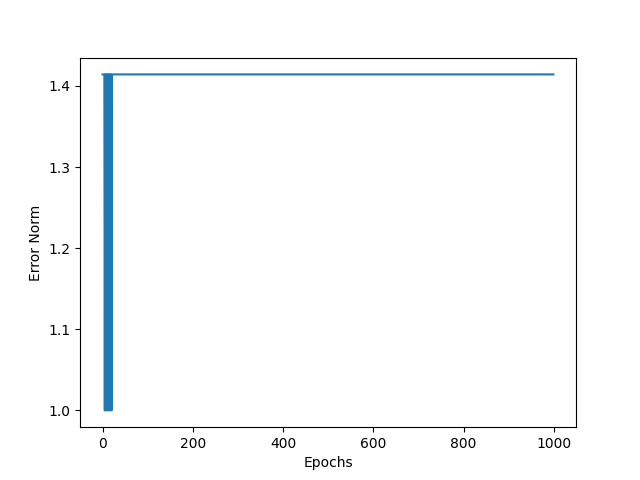

In [ ]:
np.random.seed(1)  # predictable output
# initialize perceptron
xor_gate = SinglePerceptronGate()

# train
xor_gate.train(x_2, y_xor, epochs=1000, eta=0.1)

# test
test_input = x_2
expected = y_xor
y_pred = xor_gate.apply(test_input)
error = xor_gate.error(y_pred, expected)
print("Predictions:", y_pred)
print("Error:", error)

xor_gate.inspect()

## Observation

The perceptron can be trained as an `AND` gate but not as an `XOR` gate. This is because the labelled input to the `AND` gate is linearly seperable (in fact there are infinitely many such linear classifications) but this is not true for `XOR`.

Hence a single perceptron is not sufficient to product `XOR`-gate like output.

Below we apply this problem to a multilayer perceptron network (with non-linear activation functions). 

### Reference
https://en.wikipedia.org/wiki/Perceptron#Convergence_of_one_perceptron_on_a_linearly_separable_dataset

## Implementing a multilayer perceptron (MLP) gate

`MLPGate` implements a multilayer perceptron network thats takes in exactly two inputs, and produces a *continuous* output $y_{\text{pred}} \in [0, 1]$.

It is initialized with a list `n` of number of neurons per layer.

**Note:** This name 'multilayer *perceptron* network' can be misleading since non linear activation functions are used, but this is standard. Using linear activation functions, does not offer any real advantage; the network can be expressed equivalently as a two-layer single-perceptron like network in that case.

Weights and biases are stored as lists of `np.ndarray`'s resp. and randomly initialized.

Activation function used is the ReLU function for hidden layers, and sigmoid function for output layer.

Backpropagation has been implemented for computing gradient.

Simple gradient descent is implemented using a fixed learning rate.

### Reference
https://en.wikipedia.org/wiki/Perceptron

In [76]:
class MLPGate:
    def __init__(self, n: list[int]):
        """create parameters (w and b matrices)"""

        # a[0,0]
        # a[0,0] ---- W[0] ---- g(z[0]) = a[1] --- ... --- W[L-1] --- g(z[L-1]) = a[L]
        #  ...                      |                                   |
        # a[0,n1-1]                 |                                   |
        #                           |                                   |
        # {n_features}             B[0]                                B[L-1]    {n_classes}

        # W[k,i,j] gives weight between j-th neuron of k-th layer and i-th neuron of (k+1)-th layer
        # k varies from 0 to L-1

        # len(W) = len(B) = len(z) = L = len(a) - 1
        # len(z[k]) = n[k+1] = len(a[k+1])
        # (ignoring dimension due to n_samples)

        self.n = n
        self.n_features = n[0]
        self.n_classes = n[-1]

        # inc. input total layers are len(n) = L + 1
        self.L = L = len(n) - 1

        # create list of `np.ndarray`s to deal with non-homogeneity
        self.W = list(np.empty((n[i + 1], n[i]), dtype=np.float64) for i in range(L))

        self.B = list(np.empty((n, 1), dtype=np.float64) for n in n[1:])

        # cache `a` and `z`
        self.a = list(np.empty((i, 1), dtype=np.float64) for i in n)
        self.z = list(np.empty((i, 1), dtype=np.float64) for i in n[1:])

    def initialize(self):
        """random init W and B"""
        for i in range(self.L):
            self.W[i] = np.random.randn(*self.W[i].shape)
            self.B[i] = np.random.randn(*self.B[i].shape)

    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def relu(z):
        return np.maximum(0, z)

    def forwardprop(self, x: list[float]):
        """perform forward propagation and return activation list of output layer

        Args:
            x: shape=(n_features, n_samples)
        """
        a, z = self.a, self.z
        L = self.L
        W = self.W
        B = self.B

        a[0] = x
        n_samples = a[0].shape[1]

        for k in range(L - 1):
            z[k] = W[k] @ a[k] + B[k]
            a[k + 1] = self.relu(z[k])

        # require 0 <= y_i <= 1
        z[L - 1] = W[L - 1] @ a[L - 1] + B[L - 1]
        a[L] = self.sigmoid(z[L - 1])

        # check shape
        assert a[L].shape == (self.n_classes, n_samples)

        return a[L].copy()

    def output(self, x: list[float], eps: float = 0.1):
        """Wrapper over `forwardprop` to round off output as binary if within `eps` margin, else set to -1"""
        y_pred = self.forwardprop(x)
        return np.where(y_pred < eps, 0, np.where(1 - y_pred < eps, 1, -1)).astype(int)

    @staticmethod
    def binary_cross_entropy_loss(y_pred, y):
        """return cost from output and ground truth using binary cross entropy loss

        assuming 0 <= y_pred_i <= 1, and y_i in {0,1}
        """
        # clip to prevent log(0)
        eps = 1e-15
        y_pred = np.clip(y_pred, eps, 1 - eps)

        cost = -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred), axis=1)

        return cost

    @staticmethod
    def cost_prime_times_sigmoid_prime(y_pred, y):
        # dC/d(a[L]) = (a[L] - y) / (1 - a[L]) * a[L]
        # dC/d(z[L-1]) = a[L] - y
        # we directly use this result
        # coz denominator is cancelled by sigmoid_prime

        return y_pred - y

    @staticmethod
    def relu_prime(z):
        # define as 0 on z = 0
        return np.where(z > 0, 1, 0)

    def backprop(self, y):
        """return gradient using backprop"""

        a, z, W, L = self.a, self.z, self.W, self.L

        m = y.shape[1]

        # total derivative wrt all params
        self.del_W = [None] * L
        self.del_B = [None] * L

        # del_t represents gradient of cost wrt t, flattened out
        # m = n_samples

        # output layer: del_a[L] = C'(a[L], y)                  ---> n[L], m
        # hidden layer: del_a[k] = W[k]ᵀ del_a[k+1] ⊙ g'(z[k])  ---> n[k], m
        # weights     : del_W[k] = del_a[k+1] ⊙ g'(z[k]) a[k]ᵀ  ---> n[k+1], n[k]   ==> divide by m
        # biases      : del_B[k] = del_a[k+1] ⊙ g'(z[k])        ---> n[k+1], m      ==> take mean, axis=1

        # note, additional dimension = n_samples

        # manually for k = L-1, coz sigmoid is involved
        del_z = self.cost_prime_times_sigmoid_prime(a[L], y)  # n[L], m

        self.del_B[L - 1] = np.mean(del_z, axis=1)[:, None]
        self.del_W[L - 1] = del_z @ a[L - 1].T / m

        del_a = W[L - 1].T @ del_z

        # loop for k = L-2 ... 0
        # invariant: del_a = del_a[k+1]
        for k in reversed(range(0, L - 1)):
            del_z = del_a * self.relu_prime(z[k])  # n[k+1], m

            self.del_B[k] = np.mean(del_z, axis=1)[:, None]
            self.del_W[k] = del_z @ a[k].T / m

            del_a = W[k].T @ del_z

    def optimize(self, lr: float):
        """apply gradient descent to optimize parameters"""
        # optimize using precomputed gradient
        for k in range(self.L):
            self.W[k] -= lr * self.del_W[k]
            self.B[k] -= lr * self.del_B[k]

    def train(self, x, y, epochs: int = 100, lr: float = 0.1):
        """run full cycle(s) of forwardprop -> cost eval -> backprop -> optimize"""
        # assuming initialized

        cost_history = []

        for epoch in range(epochs):
            y_pred = self.forwardprop(x)

            cost = self.binary_cross_entropy_loss(y_pred, y)

            cost_history.append(cost)

            self.backprop(y)

            self.optimize(lr)

        fig, ax = plt.subplots()
        ax.plot(np.arange(epochs), cost_history)
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Cost (averaged binary cross entropy loss)")
        # fig.show()

Predictions: [[5.58111114e-03 9.99100420e-01 9.99100417e-01 6.21219620e-04]]
Expected: [[0 1 1 0]]
Cost: 0.002004532307368153


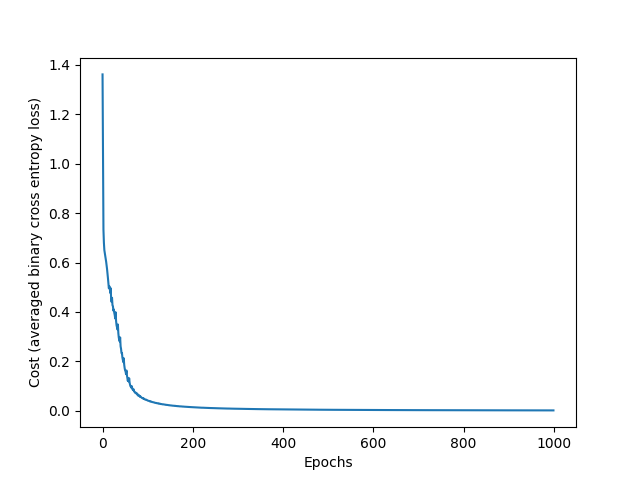

In [77]:
mlp_xor_gate = MLPGate(n=[2, 2, 1])

np.random.seed(0)

mlp_xor_gate.initialize()

mlp_xor_gate.train(x_2, y_xor, epochs = 1000, lr = 1)

test_input = x_2
expected = y_xor
y_pred = mlp_xor_gate.output(test_input)
y_pred = mlp_xor_gate.forwardprop(test_input)
cost = mlp_xor_gate.binary_cross_entropy_loss(y_pred, expected)

print("Predictions:", y_pred)
print("Expected:", expected)
print("Cost:", *cost)

In [69]:
# XOR can be exactly trained as:
# A⊕B=(A+B)⋅(NOT (A⋅B))
# 1st layer: OR, NAND gates
# 2nd layer (output): OR gate
# OR gate   : w = [1, 1]ᵀ    b = -0.5
# NAND gate : w = [-1, -1]ᵀ  b = 1.5
# this requires activation fn to be step fn

## Implementing a full carry adder

Full carry adder is implemented using `MLPGate` with 3 hidden layers with 8 neurons each, and 3 inputs `(A, B, Cin)` and 2 outputs `(Cout, S)`.

Predictions: [[0 0 0 1 0 1 1 1]
 [0 1 1 0 1 0 0 1]]
Expected: [[0 0 0 1 0 1 1 1]
 [0 1 1 0 1 0 0 1]]
Cost: 0.0002054168405903146 0.0008205917621040739


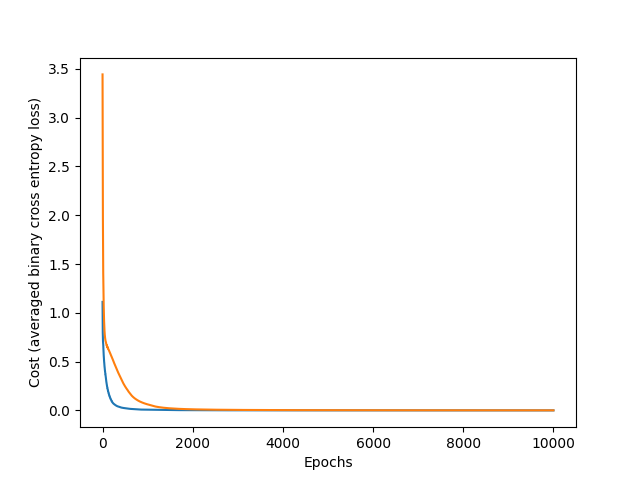

In [70]:
mlp_carry_adder = MLPGate(n=[3, 8, 8, 8, 2])

np.random.seed(1)

mlp_carry_adder.initialize()

mlp_carry_adder.train(x_3, y_carry_adder, epochs=int(1e4), lr=0.01)

test_input = x_3
expected = y_carry_adder
y_pred = mlp_carry_adder.forwardprop(test_input)
output = mlp_carry_adder.output(test_input)
cost = mlp_carry_adder.binary_cross_entropy_loss(y_pred, expected)

print("Predictions:", output)
print("Expected:", expected)
print("Cost:", *cost)

In [71]:
# trained parameters from a previously trained model

trained_W = [
    np.array(
        [
            [1.34846266, -0.94582979, -0.89542068],
            [-1.07296862, 1.09271464, -2.3015387],
            [1.7139908, -1.07479809, -0.49237976],
            [-0.80900786, 1.61627719, -2.06014071],
            [-0.36698661, -0.61998997, 1.20221531],
            [-1.09989127, -0.67740568, -0.87785842],
            [0.04221375, 0.58281521, -1.10061918],
            [1.79132741, 0.98846019, 1.13400393],
        ]
    ),
    np.array(
        [
            [
                -0.46898414,
                -0.84520564,
                -0.68232173,
                -0.01414966,
                -1.26275999,
                0.2344157,
                1.65980218,
                0.99548458,
            ],
            [
                -0.24752541,
                -1.03171652,
                -0.68894592,
                1.46707042,
                0.09363172,
                -0.7226933,
                0.19091548,
                2.75817664,
            ],
            [
                -0.01148522,
                0.61720311,
                0.22718705,
                -0.35635595,
                -1.14941353,
                -0.34934272,
                -0.20889423,
                0.47082728,
            ],
            [
                0.78478467,
                0.88942306,
                0.09923798,
                0.8188495,
                -0.42813897,
                1.24455203,
                0.51292982,
                -0.71861268,
            ],
            [
                0.90390869,
                0.05603514,
                1.39214937,
                1.7065226,
                2.22467822,
                -1.3647829,
                -1.44411381,
                -0.67238225,
            ],
            [
                0.37699465,
                0.753646,
                0.24937187,
                -2.20611615,
                -0.22956732,
                1.05413732,
                0.23009474,
                0.70936273,
            ],
            [
                -0.47644633,
                -0.08523375,
                -0.07737174,
                0.57815035,
                0.67278365,
                0.07777359,
                -0.67066229,
                -0.14610846,
            ],
            [
                0.03987965,
                1.22319173,
                1.28088986,
                0.3327311,
                -0.09224691,
                -0.76719887,
                0.42349435,
                0.1769827,
            ],
        ]
    ),
    np.array(
        [
            [
                -1.22738652,
                0.83206206,
                0.68632277,
                -0.83698574,
                -0.80441783,
                0.75004512,
                -1.43782006,
                0.48919901,
            ],
            [
                0.84616065,
                -0.85951594,
                0.35054598,
                -1.31228341,
                -0.03869551,
                -1.61577235,
                1.12141771,
                0.40890054,
            ],
            [
                -0.07502506,
                -0.77678516,
                1.25098425,
                1.81170879,
                -2.07877223,
                1.40965997,
                1.57643922,
                0.13511066,
            ],
            [
                -1.25060623,
                0.76588159,
                -0.20420556,
                -0.34819832,
                -1.20892381,
                0.85851822,
                0.80830073,
                -0.53095077,
            ],
            [
                0.51261774,
                -1.85052125,
                0.79723359,
                0.74896149,
                0.34048057,
                -0.03531783,
                1.09499228,
                0.93034345,
            ],
            [
                0.49145744,
                -0.03340992,
                0.06457249,
                0.90684099,
                0.23249234,
                0.86993076,
                -0.28292318,
                -2.37581722,
            ],
            [
                1.22306085,
                2.29847123,
                0.51987666,
                -0.34932113,
                -0.41563565,
                -0.65193487,
                -0.28588118,
                -1.53541897,
            ],
            [
                -0.51709446,
                -0.96114128,
                0.24645645,
                0.01800534,
                0.73906779,
                -0.22533777,
                1.11732942,
                0.74666568,
            ],
        ]
    ),
    np.array(
        [
            [
                1.50069154,
                -0.28730786,
                -0.22684491,
                -0.1266667,
                -2.49569116,
                0.15721142,
                0.61183864,
                1.00220967,
            ],
            [
                -1.51384183,
                -0.61736206,
                -1.08452635,
                -0.66125541,
                0.93457694,
                -0.6381594,
                2.05686582,
                1.31532892,
            ],
        ]
    ),
]

trained_B = [
    np.array(
        [
            [1.05599669],
            [-0.45642085],
            [-0.14681456],
            [-0.78160018],
            [-0.19944222],
            [0.67740544],
            [-0.69166075],
            [-1.01709674],
        ]
    ),
    np.array(
        [
            [-0.61413759],
            [-0.46059997],
            [-0.69322259],
            [0.89330308],
            [-0.10833775],
            [1.64359901],
            [0.65319735],
            [1.16516784],
        ]
    ),
    np.array(
        [
            [2.32681776],
            [-1.89636092],
            [-0.65513091],
            [1.03541232],
            [2.88344679],
            [-0.13330383],
            [-0.39956508],
            [-0.16513681],
        ]
    ),
    np.array([[1.69152653], [0.73527322]]),
]


## Implementing a ripple carry adder

Ripple carry adder is implemented below, by chaining `n` trained full adder networks from above (for adding `n`-length bitstrings with 1 carry bit).

In [78]:
def ripple_carry_adder(A: str, B: str, Cin: str, trained_full_adder: MLPGate):
    """
    Implements a ripple carry adder adding bitstrings `A`, `B` with carry `Cin`, using a `trained_full_adder` network

    - `A = A_{n-1}...A_0`
    - `B = B_{n-1}...B_0`

    output is given in the form LSB...MSB
    `MSB = A_0 ⊗ B_0 ⊗ Cin`
    """
    assert len(A) == len(B) and len(Cin) == 1

    n = len(A)

    x = np.vstack((tuple(map(int, tuple(A))), tuple(map(int, tuple(B))), (0,) * n))

    # reverse order so that MSB gets added first (loop goes left to right)
    x = x[:, ::-1]

    # print(x)

    sum, c = [], int(Cin)

    for i in range(n):
        x[2, i] = c

        x_i = x[:, i][:, None]
        c, s = trained_full_adder.output(x_i)[:, 0]

        sum.append(s)

        # print(f"{x_i.T} \t=> {s}, {c}")

    sum_str = "".join(map(str, sum[::-1]))

    print(f"Cin  {A} = A")
    print(f"{Cin}  + {B} = B")
    print("-" * (5 + n + 4))
    print(f"{c}    {sum_str}")
    print()

    return sum_str, c

In [79]:
# pre trained parameters
pretrained_adder = MLPGate(n=[3, 8, 8, 8, 2])
pretrained_adder.W = trained_W
pretrained_adder.B = trained_B

# testing sample outputs

_ = ripple_carry_adder('0010','1101', '0', pretrained_adder)
_ = ripple_carry_adder('1010','0111', '1', pretrained_adder)
_ = ripple_carry_adder('1111','0101', '1', pretrained_adder)

Cin  0010 = A
0  + 1101 = B
-------------
0    1111

Cin  1010 = A
1  + 0111 = B
-------------
1    0010

Cin  1111 = A
1  + 0101 = B
-------------
1    0101

